In [14]:
from pathlib import Path
import duckdb
from textwrap import dedent
from datetime import datetime
from transformers import (
    AutoTokenizer, 
)
from sklearn.metrics import classification_report
from src.model_train.func import MultiLabels, TrainDistribution, preprocess_data
from src.model_train.pipeline_train import Pipeline

In [2]:
path = Path('/media/kevin/data_4t/cx_product_review/training_data')

file = path / 'eda_issue.parquet'
l1 = ['product_quality', 'pricing', 'delivery_service', 'packaging', 'seller_service', 'listing_accuracy', 'irrelevant']
labels = [f'issue_{i}' for i in l1]

query = f"""
select distinct 
item_id
, item_name
, comment_id
, comment
, {'\n, '.join(f'coalesce(issue_{i}, 0) issue_{i}' for i in l1)}
from read_parquet('{file}')
"""
df = duckdb.sql(query).pl()

print(df.shape, df['comment_id'].n_unique())
print(df.null_count().to_dict(as_series=False))
df.head()

(74013, 11) 73994
{'item_id': [0], 'item_name': [0], 'comment_id': [0], 'comment': [0], 'issue_product_quality': [0], 'issue_pricing': [0], 'issue_delivery_service': [0], 'issue_packaging': [0], 'issue_seller_service': [0], 'issue_listing_accuracy': [0], 'issue_irrelevant': [0]}


item_id,item_name,comment_id,comment,issue_product_quality,issue_pricing,issue_delivery_service,issue_packaging,issue_seller_service,issue_listing_accuracy,issue_irrelevant
i64,str,i64,str,i64,i64,i64,i64,i64,i64,i32
21394858299,"""SANRIO Bút Mực gel Ngòi 0.5mm …",14031601793,"""Chất lượng sản phẩm:cute nắm Đ…",0,0,0,0,0,0,1
2027330336,"""[Chaang ] Bộ cài vai dài tay C…",1373272587,"""Mịn rất đẹp đáng tiền""",0,0,0,0,0,0,1
24363579486,"""Vớ cổ thấp dành cho nam nữ""",14222752709,"""Siêu đẹp. Chất siêu thích . Cỡ…",0,0,0,0,0,0,1
6307844444,"""[E-voucher] Mã Quà Tặng Shopee…",1838913170,"""Sản phẩm tốt. Chúc shop bán đắ…",0,0,0,0,0,0,1
6307844444,"""[E-voucher] Mã Quà Tặng Shopee…",1838201135,"""Chất lượng sản phảm tuyêtj vời…",0,0,0,0,0,0,1


In [3]:
TrainDistribution.label_stats(df, 'all', labels)

name,val,pct,data
str,i64,f64,str
"""issue_product_quality""",26187,0.353816,"""all"""
"""issue_pricing""",1892,0.025563,"""all"""
"""issue_delivery_service""",6951,0.093916,"""all"""
"""issue_packaging""",3154,0.042614,"""all"""
"""issue_seller_service""",6936,0.093713,"""all"""
"""issue_listing_accuracy""",15679,0.211841,"""all"""
"""issue_irrelevant""",29605,0.399997,"""all"""


Shape Train: (47368, 11), Valid: (11842, 11), Test: (14803, 11)


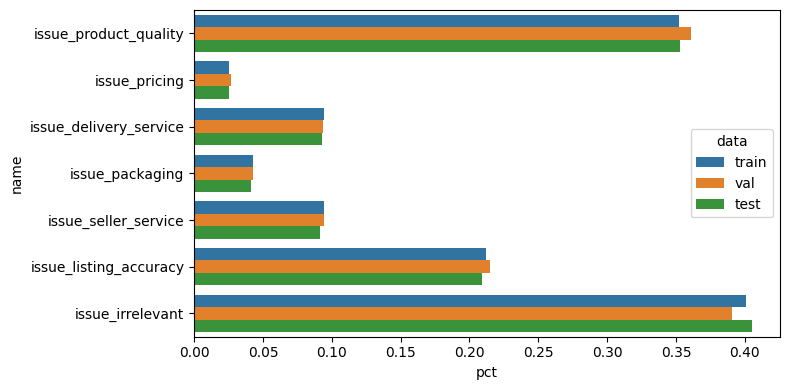

In [4]:
dist_check = TrainDistribution(df)
train, val, test = dist_check.split_train_valid_test(test_size=.2)
dist_check.check(labels)

In [5]:
col = ['comment_id', 'comment'] + labels
id2label = {idx:label for idx, label in enumerate(labels)}
label2id = {label:idx for idx, label in enumerate(labels)}

ds_train, ds_test, ds_val = dist_check.split_to_dataset(col, show_index=3)

Show example: 3
        Train: {'comment_id': 624928204, 'comment': ' Chất lượng sản phẩm tuyệt vời Shop phục vụ rất tốt Rất đáng tiền Thời gian giao hàng rất nhanh', 'issue_product_quality': 0, 'issue_pricing': 0, 'issue_delivery_service': 0, 'issue_packaging': 0, 'issue_seller_service': 0, 'issue_listing_accuracy': 0, 'issue_irrelevant': 1}
        Test: {'comment_id': 14510755336, 'comment': 'Chất lượng sản phẩm:tạm ổn\nĐúng với mô tả:90%\n\nNhận hàng về thì thấy khung bị vỡ 1 góc nên phải mua keo 502 về dán lại cho chắc. Nma thh dùng cx đc 🥲', 'issue_product_quality': 1, 'issue_pricing': 0, 'issue_delivery_service': 0, 'issue_packaging': 0, 'issue_seller_service': 0, 'issue_listing_accuracy': 0, 'issue_irrelevant': 0}
        Val: {'comment_id': 11372688855, 'comment': 'Giao hàng như cái đb ngta đặt full đen giao trắng\nCụ m bán hàng thế à\nĐã thế còn in lỗi chứ\nQuao thì mỏng', 'issue_product_quality': 1, 'issue_pricing': 0, 'issue_delivery_service': 1, 'issue_packaging': 0, 'issu

In [6]:
pretrain_name = 'bkai-foundation-models/vietnamese-bi-encoder'
tokenizer = AutoTokenizer.from_pretrained(pretrain_name)

In [7]:
train_encoded_dataset = ds_train.map(
    preprocess_data, 
    batched=True, 
    remove_columns=ds_train.column_names, 
    fn_kwargs={'labels': labels, 'tokenizer': tokenizer}
)
val_encoded_dataset = ds_val.map(
    preprocess_data, 
    batched=True, 
    remove_columns=ds_train.column_names, 
    fn_kwargs={'labels': labels, 'tokenizer': tokenizer}
)
test_encoded_dataset = ds_test.map(
    preprocess_data, 
    batched=True, 
    remove_columns=ds_train.column_names, 
    fn_kwargs={'labels': labels, 'tokenizer': tokenizer}
)

train_encoded_dataset.set_format('torch')
val_encoded_dataset.set_format('torch')
test_encoded_dataset.set_format('torch')

Map:   0%|          | 0/47368 [00:00<?, ? examples/s]

Map:   0%|          | 0/11842 [00:00<?, ? examples/s]

Map:   0%|          | 0/14803 [00:00<?, ? examples/s]

In [8]:
example = train_encoded_dataset[0]
print(example.keys())
print(tokenizer.decode(example['input_ids']))
print([id2label[idx] for idx, label in enumerate(example['labels']) if label == 1.0])

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'labels'])
<s> Không đánh giá đến mì, đánh giá cái cách shop đóng gói hàng mà hàng nát hết cả ra. Giao thùng mì mà kh có tí chống sốc nào, mì giao về bể nát, không biết nấu ăn mì trộn kiểu </s>
['issue_delivery_service', 'issue_packaging']


In [9]:
pretrain_name = 'bkai-foundation-models/vietnamese-bi-encoder'
pipe = Pipeline(pretrain_name=pretrain_name, id2label=id2label, label2id=label2id)

time_now = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
folder = path / f'model_multi_labels_issue/{pretrain_name.split('/')[-1]}/{time_now}'
config = dict(    
    log_step=100,
    num_train_epochs=7,
    learning_rate=1e-4,
)
trainer = pipe.train(
    folder=folder, 
    train=train_encoded_dataset,
    val=val_encoded_dataset,
    **config
)

Pretrain: bkai-foundation-models/vietnamese-bi-encoder


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at bkai-foundation-models/vietnamese-bi-encoder and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,F1,Roc Auc,Accuracy
100,0.377700,0.198485,0.765659,0.832524,0.659770
200,0.169000,0.151847,0.825864,0.884907,0.720824
300,0.122500,0.133079,0.855612,0.913959,0.756207
400,0.094700,0.136108,0.855626,0.908795,0.764736
500,0.075000,0.136961,0.859829,0.913316,0.768958
600,0.064100,0.139818,0.859090,0.913829,0.768113


***** train metrics *****
  epoch                    =        7.0
  total_flos               =  7934907GF
  train_loss               =     0.1434
  train_runtime            = 0:02:27.46
  train_samples_per_second =    2248.53
  train_steps_per_second   =      4.415


In [10]:
valid_result = trainer.predict(val_encoded_dataset)
print(valid_result.metrics)

valid_y_pred = MultiLabels().post_process(valid_result.predictions)
valid_report = classification_report(valid_result.label_ids, valid_y_pred, target_names=labels)
print(valid_report)

{'test_loss': 0.13696089386940002, 'test_f1': 0.8598292970647422, 'test_roc_auc': 0.9133157732473575, 'test_accuracy': 0.768957946292856, 'test_runtime': 1.8296, 'test_samples_per_second': 6472.411, 'test_steps_per_second': 101.661}
                        precision    recall  f1-score   support

 issue_product_quality       0.87      0.87      0.87      4271
         issue_pricing       0.67      0.47      0.56       315
issue_delivery_service       0.81      0.81      0.81      1105
       issue_packaging       0.76      0.74      0.75       509
  issue_seller_service       0.80      0.81      0.80      1118
issue_listing_accuracy       0.81      0.81      0.81      2547
      issue_irrelevant       0.94      0.93      0.93      4628

             micro avg       0.86      0.85      0.86     14493
             macro avg       0.81      0.78      0.79     14493
          weighted avg       0.86      0.85      0.86     14493
           samples avg       0.88      0.88      0.87     144

/home/kevin/miniforge3/envs/llm/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [11]:
test_result = trainer.predict(test_encoded_dataset)
print(test_result.metrics)

test_y_pred = MultiLabels().post_process(test_result.predictions)
test_report = classification_report(test_result.label_ids, test_y_pred, target_names=labels)
print(test_report)

{'test_loss': 0.13392189145088196, 'test_f1': 0.859320898023009, 'test_roc_auc': 0.9126605818326229, 'test_accuracy': 0.769438627305276, 'test_runtime': 2.2408, 'test_samples_per_second': 6606.133, 'test_steps_per_second': 103.535}
                        precision    recall  f1-score   support

 issue_product_quality       0.87      0.87      0.87      5222
         issue_pricing       0.64      0.44      0.52       377
issue_delivery_service       0.80      0.80      0.80      1376
       issue_packaging       0.76      0.75      0.76       611
  issue_seller_service       0.79      0.81      0.80      1353
issue_listing_accuracy       0.81      0.80      0.80      3094
      issue_irrelevant       0.95      0.92      0.93      6000

             micro avg       0.87      0.85      0.86     18033
             macro avg       0.80      0.77      0.78     18033
          weighted avg       0.86      0.85      0.86     18033
           samples avg       0.88      0.88      0.87     1803

/home/kevin/miniforge3/envs/llm/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [19]:
path_md = str(path / f'model_multi_labels_issue/{pretrain_name.split('/')[-1]}/result_{time_now}.md')
with open(path_md, 'w', encoding="utf-8") as md:
    text = dedent(f"""
    Config:
    {config}
    
    Valid Classification Report:
    {valid_report}
    
    Test Classification Report:
    {test_report}
    """)
    md.write(text)